In [1]:
# Importing packages
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python

import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trig etc.
import random
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

import itertools
from itertools import combinations

# Setting directory
# os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_test") # set the working directory

# Comment these out later
import warnings
warnings.filterwarnings('ignore')

# Running mean function
def running_mean(in_array,window):
    import numpy as np
    w = int(np.floor(window/2))
    mean_array = np.zeros(len(in_array),dtype=np.float64)
    i = int(w)
    while i < len(in_array)-w:
        mean_array[i] = np.mean(in_array[(i-w):(i+w+1)])
        i += 1
    window_used = int(w*2 +1)
    return(mean_array,window_used)

In [2]:
# Importing data
data_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/CostaRica_Chemistry_20200518.csv'
data_2_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/lia_Q.csv' # DS Q
data_3_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/UpQDataSlam.csv'# US Q
data_4_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/down_q_measured.csv'# DS Q Measured
data_5_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/up_q_measured.csv'# US Q Measured
data_6_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/DownstreamMiller.csv' # Rain
data_7_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/Ratios/Ratios.csv' # US/DS ratios

# Read data from url as pandas dataframe
df = pd.read_csv(data_url)
df2 = pd.read_csv(data_2_url)
df3 = pd.read_csv(data_3_url)
df4 = pd.read_csv(data_4_url)
df5 = pd.read_csv(data_5_url)
df6 = pd.read_csv(data_6_url)
df7 = pd.read_csv(data_7_url)

# Making date columns datetime friendly (in case I wanted to index later)
df['SamplingDate'] = pd.to_datetime(df['SamplingDate'])
df['Chemetrics_Acidified_Date'] = pd.to_datetime(df['Chemetrics_Acidified_Date'])
df2['Date'] = pd.to_datetime(df2['Date'])
df3['Date'] = pd.to_datetime(df3['Date'])
df4['Date'] = pd.to_datetime(df4['Date'])
df5['Date'] = pd.to_datetime(df5['Date'])
df6['Date'] = pd.to_datetime(df6['Date'])

# Filtering endmembers
df_rain = df[df['Site'] == "Rain"].reset_index(drop=True) # Endmember 1 = Rain
df_soil = df[df['Site'] == "Soil"].reset_index(drop=True) # Endmember 2 = Soil
df_spring = df[df['Site'] == "Spring"].reset_index(drop=True) # Endmember 3a = Spring
df_us = df[(df['Site'] == "Upstream") & (df['SamplingDate'] < '2019')].reset_index(drop=True) # Endmember 3b = Upstream, not including 2019

# Filtering mixing batches
df_ds = df[(df['Site'] == "Downstream") & (df['SamplingDate'] < '2019')] # Mixing batch a, not including 2019
df_ds = df_ds[~df_ds['ID'].str.contains("Howler")] # Only want the DS samples
df_ds = df_ds[~df_ds['ID'].str.contains("DS9Bot")].reset_index(drop=True) # Filtering out DS9Bot (duplicate)
df_stream = df[(df['Source'] == "Stream") & (df['SamplingDate'] < '2019')].reset_index() # Mixing batch b, not including 2019

# Summary statistics:
df_summary = df.groupby("Site").describe()

# For this analysis, I'm dropping the US samples that are missing 
# from the DS samples (because the ISCO was not installed correctly):
# Samples 4 - 8
df_us = df_us.drop(df_us.index[3:8]).reset_index(drop=True)
# df_us = df_us.drop(df_us.index[4]).reset_index(drop=True) # Dropping sample 10
# df_ds = df_ds.drop(df_ds.index[4]).reset_index(drop=True) # Dropping sample 10

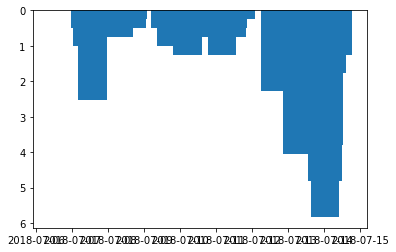

In [3]:
# Adding running mean to US and DS hydrograph
ds_q = df2['Q'].to_numpy() # taking discharge values
rm_ds_q = running_mean(ds_q, 5) # returns 2-D array with running mean, making first two values and last two values 0, AND returning the window used.

us_q = df3['Q'].to_numpy()
rm_us_q = running_mean(us_q, 5)

df2['MovingAverage5'] = rm_ds_q[0]  # only care about first array with moving average
df3['MovingAverage5'] = rm_us_q[0] 

df2['MovingAverage5'] = df2['MovingAverage5'].replace([0], np.nan) # replace first and last two values with NaNs
df3['MovingAverage5'] = df3['MovingAverage5'].replace([0], np.nan)

# Rain df6
df6_copy = df6.copy()
df6_copy['Rain'] = -1 * df6_copy['Rain']

fig, ax = plt.subplots()
ax.bar(df6_copy['Date'], df6_copy['Rain'])
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
plt.show()

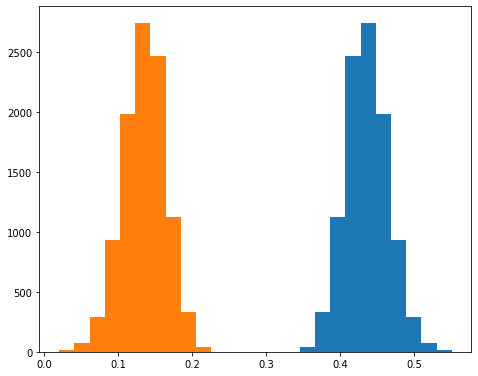

In [20]:
#### WITH WELLS

# Changing working directory
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_20200918") # set the working directory

# masking DS2,3
ratios = df7.copy()
ratios = ratios.drop(ratios.index[1:3]).reset_index(drop=True)

df = df[df['SamplingDate'] < '2019'].reset_index(drop=True)

var = ['SO4','Cl','O18','D'] # variables of interest
L = 10000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

# to_drop_2 = ['Well']
# df = df[~df['ID'].isin(to_drop_2)].reset_index(drop=True)

df_summary = df.groupby("Site").describe() # Rain (n=2), Spring (n=2), Soil (including wells)

# Filtering endmembers
df_rain = df[df['Site'] == "Rain"].reset_index(drop=True) # Endmember 1 = Rain
df_soil = df[df['Site'] == "Soil"].reset_index(drop=True) # Endmember 2 = Soil
df_spring = df[df['Site'] == "Spring"].reset_index(drop=True) # Endmember 3a = Spring

to_drop = ['DS2', 'DS3', 'DS10']
df_ds = df_ds[~df_ds['ID'].isin(to_drop)].reset_index(drop=True)

# 1) I want to loop through every unique pair of endmembers
for pair in var: # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair]['mean']['Rain']
    rain_1_stdev = df_summary[pair]['std']['Rain']
    soil_1_mean = df_summary[pair]['mean']['Soil']
    soil_1_stdev = df_summary[pair]['std']['Soil']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    pf = []
    soil_m = []
    rain_m = []
    soil_s = []
    rain_s = []
    # 4) Loop through each sample
    for x in range(0, len(df_ds)): # Should be DS1 - DS26, minus the ones taken out earlier
        sample = df_ds['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        up_f_1 = np.repeat((ratios['Ratio'][x]), L) 
        up_1 = np.repeat((df_us[pair][x]), L) # Making repeated arrays for up and down samples
        down_1 = np.repeat((df_ds[pair][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[soil_1[i], rain_1[i]], [ones[i], ones[i]]])
            b = np.array([down_1[i]-(up_f_1[i]*up_1[i]), ones[i]-up_f_1[i]])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            soil_f.append(results[k][0])
            rain_f.append(results[k][1])
        # 7) Subplots (# of rows, # of columns, unique position)
        plt.subplot(311)
        GSLIB.hist_st(up_f_1,0,1,log=False,cumul=False,bins=256,weights=None,xlabel="Up Fraction",title="Up Fraction: {0} with {1}".format(sample, pair))
        plt.ylim(0.0,1000)
        # ~~~~~~~~~~~~~~~
        plt.subplot(312)
        GSLIB.hist_st(soil_f,0,1,log=False,cumul=False,bins=256,weights=None,xlabel="Soil Fraction",title="Soil Fraction: {0} with {1}".format(sample, pair))
        plt.ylim(0.0,1000)
        # ~~~~~~~~~~~~~~~
        plt.subplot(313)
        GSLIB.hist_st(rain_f,0,1,log=False,cumul=False,bins=256,weights=None,xlabel="Rain Fraction",title="Rain Fraction: {0} with {1}".format(sample, pair))
        plt.ylim(0.0,1000)
        # ~~~~~~~~~~~~~~~
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.8)
        plt.savefig("Graph" + str(sample) + str(pair) + ".png", bbox_inches = 'tight') # MUST have bbox_inches
        plt.clf()   # closes figure so you can loop to next sample
        # Let's pull out values now!
        mc = pd.DataFrame({'sample':np.repeat(sample, L),'up':up_f_1,'soil':soil_f, 'rain':rain_f})
        mc = mc[(mc['soil'] > 0) & (mc['soil'] < 1)].reset_index(drop=True) # get rid of unrealistic values
        mc = mc[(mc['rain'] > 0) & (mc['rain'] < 1)].reset_index(drop=True)
        y1, x1, _ = plt.hist(mc['soil'])
        y2, x2, _ = plt.hist(mc['rain'])
        soil_std = mc['soil'].std()
        rain_std = mc['rain'].std()
        soil_mode = x1[np.where(y1 == y1.max())]
        rain_mode = x2[np.where(y2 == y2.max())]
        pf.append(len(mc)/10000)
        soil_m.append(soil_mode)
        rain_m.append(rain_mode)
        soil_s.append(soil_std)
        rain_s.append(rain_std)
    pf = pd.DataFrame(pf)
    pf.to_csv(pair+'.csv', index=False)
    soil_m = pd.DataFrame({'soil_m':soil_m, 'soil_s':soil_s})
    rain_m = pd.DataFrame({'rain_m':rain_m,'rain_s':rain_s})
    soil_m.to_csv(pair + 'soilmode.csv', index=False)
    rain_m.to_csv(pair + 'rainmode.csv', index=False)
        

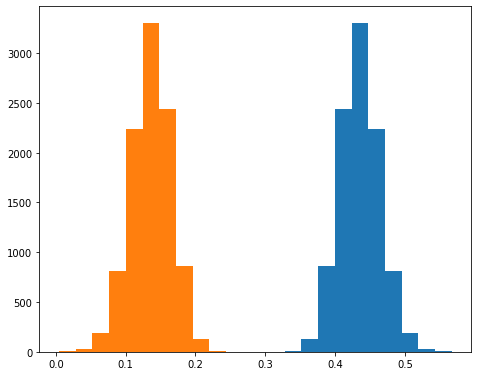

In [22]:
#### WITHOUT WELLS

# Changing working directory
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_20200918_without_wells") # set the working directory

# masking DS2,3
ratios = df7.copy()
ratios = ratios.drop(ratios.index[1:3]).reset_index(drop=True)

df = df[df['SamplingDate'] < '2019'].reset_index(drop=True)

var = ['SO4','Cl','O18','D'] # variables of interest
L = 10000 # Number of MCS realizations
ones = np.repeat(1, L) # numpy array of L ones
# list(itertools.combinations(var, 2)) # generates list of combinations

to_drop_2 = ['Well']
df = df[~df['ID'].isin(to_drop_2)].reset_index(drop=True)

df_summary = df.groupby("Site").describe() # Rain (n=2), Spring (n=2), Soil (constrained to seeps HW Trib and USLB)

# Filtering endmembers
df_rain = df[df['Site'] == "Rain"].reset_index(drop=True) # Endmember 1 = Rain
df_soil = df[df['Site'] == "Soil"].reset_index(drop=True) # Endmember 2 = Soil
df_spring = df[df['Site'] == "Spring"].reset_index(drop=True) # Endmember 3a = Spring


to_drop = ['DS2', 'DS3', 'DS10']
df_ds = df_ds[~df_ds['ID'].isin(to_drop)].reset_index(drop=True)

# 1) I want to loop through every unique pair of endmembers
for pair in var: # Will make unique combinations from the four variables: in total 6 pairs
    # 2) Deal with endmember pairs: Rain and Soil
    rain_1_mean = df_summary[pair]['mean']['Rain']
    rain_1_stdev = df_summary[pair]['std']['Rain']
    soil_1_mean = df_summary[pair]['mean']['Soil']
    soil_1_stdev = df_summary[pair]['std']['Soil']
    # 3) Apply normal distribution to draw L realizations for each variable and storing them in ndarrays
    rain_1 = np.random.normal(rain_1_mean, rain_1_stdev, size = L)
    soil_1 = np.random.normal(soil_1_mean, soil_1_stdev, size = L)
    pf = []
    soil_m = []
    rain_m = []
    soil_s = []
    rain_s = []
    # 4) Loop through each sample
    for x in range(0, len(df_ds)): # Should be DS1 - DS26, minus the ones taken out earlier
        sample = df_ds['ID'][x] # saving sample name for graphs (i.e. 'DS1')
        up_f_1 = np.repeat((ratios['Ratio'][x]), L) 
        up_1 = np.repeat((df_us[pair][x]), L) # Making repeated arrays for up and down samples
        down_1 = np.repeat((df_ds[pair][x]), L)
        results = [] # Making an empty array to hold appended results of solved linear equations in next code block
        # 5) Set up linear equations to solve for endmember fractions
        for i in range(0, L):
            a = np.array([[soil_1[i], rain_1[i]], [ones[i], ones[i]]])
            b = np.array([down_1[i]-(up_f_1[i]*up_1[i]), ones[i]-up_f_1[i]])
            results.append(np.linalg.solve(a,b)) # this function will solve for a,b
        soil_f = []
        rain_f = []
        # 6) Take each endmember's fraction and append it to a numpy array
        for k in range(0,L):
            soil_f.append(results[k][0])
            rain_f.append(results[k][1])
        # 7) Subplots (# of rows, # of columns, unique position)
        plt.subplot(311)
        GSLIB.hist_st(up_f_1,0,1,log=False,cumul=False,bins=256,weights=None,xlabel="Up Fraction",title="Up Fraction: {0} with {1}".format(sample, pair))
        plt.ylim(0.0,1000)
        # ~~~~~~~~~~~~~~~
        plt.subplot(312)
        GSLIB.hist_st(soil_f,0,1,log=False,cumul=False,bins=256,weights=None,xlabel="Soil Fraction",title="Soil Fraction: {0} with {1}".format(sample, pair))
        plt.ylim(0.0,1000)
        # ~~~~~~~~~~~~~~~
        plt.subplot(313)
        GSLIB.hist_st(rain_f,0,1,log=False,cumul=False,bins=256,weights=None,xlabel="Rain Fraction",title="Rain Fraction: {0} with {1}".format(sample, pair))
        plt.ylim(0.0,1000)
        # ~~~~~~~~~~~~~~~
        plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.8)
        plt.savefig("Graph" + str(sample) + str(pair) + ".png", bbox_inches = 'tight') # MUST have bbox_inches
        plt.clf()   # closes figure so you can loop to next sample
        # Let's pull out values now!
        mc = pd.DataFrame({'sample':np.repeat(sample, L),'up':up_f_1,'soil':soil_f, 'rain':rain_f})
        mc = mc[(mc['soil'] > 0) & (mc['soil'] < 1) & (mc['rain'] > 0) & (mc['rain'] < 1)].reset_index(drop=True) # get rid of unrealistic values
        y1, x1, _ = plt.hist(mc['soil'])
        y2, x2, _ = plt.hist(mc['rain'])
        soil_mode = x1[np.where(y1 == y1.max())]
        rain_mode = x2[np.where(y2 == y2.max())]
        soil_std = mc['soil'].std()
        rain_std = mc['rain'].std()
        pf.append(len(mc)/10000)
        soil_m.append(soil_mode)
        rain_m.append(rain_mode)
        soil_s.append(soil_std)
        rain_s.append(rain_std)
    pf = pd.DataFrame(pf)
    pf.to_csv(pair+'.csv', index=False)
    soil_m = pd.DataFrame({'soil_m':soil_m, 'soil_s':soil_s})
    rain_m = pd.DataFrame({'rain_m':rain_m,'rain_s':rain_s})
    soil_m.to_csv(pair + 'soilmode.csv', index=False)
    rain_m.to_csv(pair + 'rainmode.csv', index=False)
        

In [19]:
os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_20200918_without_wells")


0.029030439135180792